# Colorado Motor Vehicle Sales Data Analysis Project

**Domain:** Finance Analyst  
**Tools:** Python, Pandas, Matplotlib, Seaborn, Scikit-learn, Statsmodels  
**Objective:** Analyze motor vehicle sales data in Colorado to identify trends, forecast future sales, and understand factors influencing sales.


## Project Overview

This dataset contains information on motor vehicle sales in various counties across Colorado, segmented by year and quarter.

**Columns:**
- **Year:** Calendar year of sales
- **Quarter:** Q1 (Jan-Mar), Q2 (Apr-Jun), Q3 (Jul-Sep), Q4 (Oct-Dec)
- **County:** County in Colorado
- **Sales:** Total dollar amount of motor vehicle sales

##  Import Libraries and Load Data

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [24]:
# Load the dataset
df = pd.read_excel('colorado_motor_vehicle_sales.xlsx')

print("Dataset loaded successfully!")
print(f"\nDataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Dataset loaded successfully!

Dataset shape: (501, 4)

Columns: ['year', 'quarter', 'county', 'sales']


,year,quarter,county,sales
0,2008,1,Adams,231609000
1,2008,1,Arapahoe,550378000
2,2008,1,Boulder/Broomfield,176771000
3,2008,1,Denver,200103000
4,2008,1,Douglas,93259000


##  Data Preparation

In [4]:
# Create a period column combining year and quarter
df['period'] = df['year'].astype(str) + ' Q' + df['quarter'].astype(str)

# Create a date column for time series analysis
# Q1 = March 31, Q2 = June 30, Q3 = Sept 30, Q4 = Dec 31
def quarter_to_date(row):
    quarter_end = {1: '03-31', 2: '06-30', 3: '09-30', 4: '12-31'}
    return pd.to_datetime(f"{row['year']}-{quarter_end[row['quarter']]}")

df['date'] = df.apply(quarter_to_date, axis=1)

# Convert sales to millions for better readability
df['sales_millions'] = df['sales'] / 1_000_000

print("Data preparation completed!")
df.head()

Data preparation completed!


,year,quarter,county,sales,period,date,sales_millions
0,2008,1,Adams,231609000,2008 Q1,2008-03-31,231.609
1,2008,1,Arapahoe,550378000,2008 Q1,2008-03-31,550.378
2,2008,1,Boulder/Broomfield,176771000,2008 Q1,2008-03-31,176.771
3,2008,1,Denver,200103000,2008 Q1,2008-03-31,200.103
4,2008,1,Douglas,93259000,2008 Q1,2008-03-31,93.259


In [5]:
# Data overview
print("=" * 60)
print("DATA INFORMATION")
print("=" * 60)
print(f"\nTime Period: {df['year'].min()} - {df['year'].max()}")
print(f"Total Records: {len(df):,}")
print(f"Number of Counties: {df['county'].nunique()}")
print(f"\nCounties: {', '.join(sorted(df['county'].unique()))}")

print("\n" + "=" * 60)
print("MISSING VALUES")
print("=" * 60)
print(df.isnull().sum())

print("\n" + "=" * 60)
print("BASIC STATISTICS")
print("=" * 60)
print(df[['year', 'quarter', 'sales_millions']].describe())

DATA INFORMATION

Time Period: 2008 - 2015
Total Records: 501
Number of Counties: 17

Counties: Adams, Arapahoe, Boulder, Boulder/Broomfield, Broomfield, Denver, Douglas, El Paso, Fremont, Garfield, Jefferson, La Plata, Larimer, Mesa, Pueblo, Rest of State, Weld

MISSING VALUES
year              0
quarter           0
county            0
sales             0
period            0
date              0
sales_millions    0
dtype: int64

BASIC STATISTICS
              year     quarter  sales_millions
count   501.000000  501.000000      501.000000
mean   2011.570858    2.502994      176.058483
std       2.266599    1.120041      164.205510
min    2008.000000    1.000000        6.274000
25%    2010.000000    2.000000       61.482000
50%    2012.000000    3.000000      138.582000
75%    2014.000000    4.000000      224.158000
max    2015.000000    4.000000      916.910000


##  Exploratory Data Analysis (EDA)

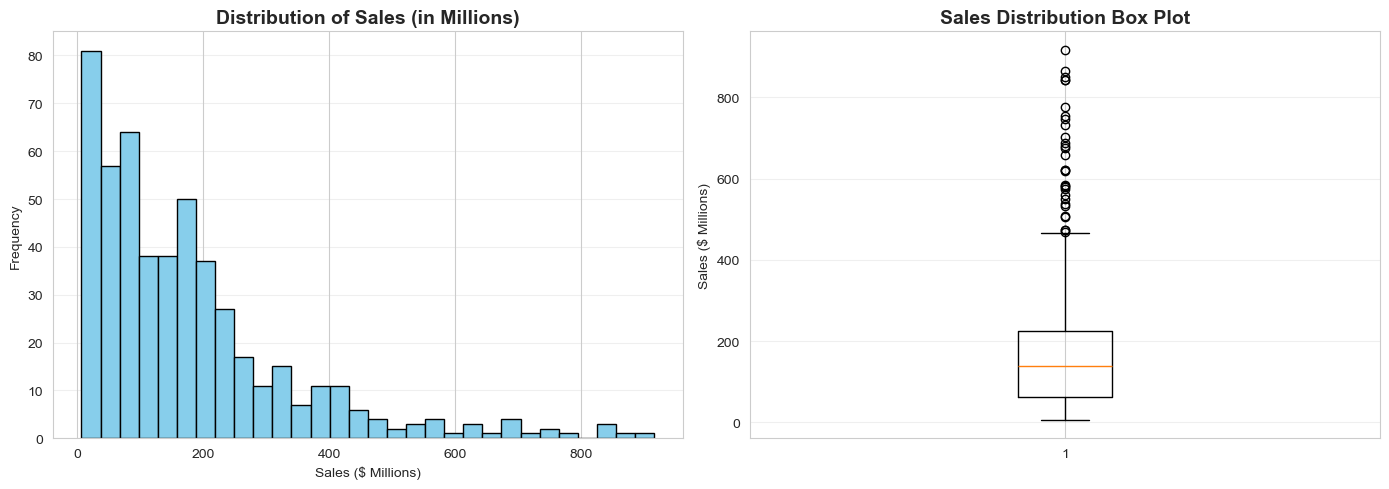


Sales Statistics:
Mean: $176.06M
Median: $138.58M
Std Dev: $164.21M
Min: $6.27M
Max: $916.91M


In [6]:
# Distribution of sales
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df['sales_millions'], bins=30, edgecolor='black', color='skyblue')
axes[0].set_title('Distribution of Sales (in Millions)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sales ($ Millions)')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y', alpha=0.3)

# Box plot
axes[1].boxplot(df['sales_millions'], vert=True)
axes[1].set_title('Sales Distribution Box Plot', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Sales ($ Millions)')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSales Statistics:")
print(f"Mean: ${df['sales_millions'].mean():.2f}M")
print(f"Median: ${df['sales_millions'].median():.2f}M")
print(f"Std Dev: ${df['sales_millions'].std():.2f}M")
print(f"Min: ${df['sales_millions'].min():.2f}M")
print(f"Max: ${df['sales_millions'].max():.2f}M")

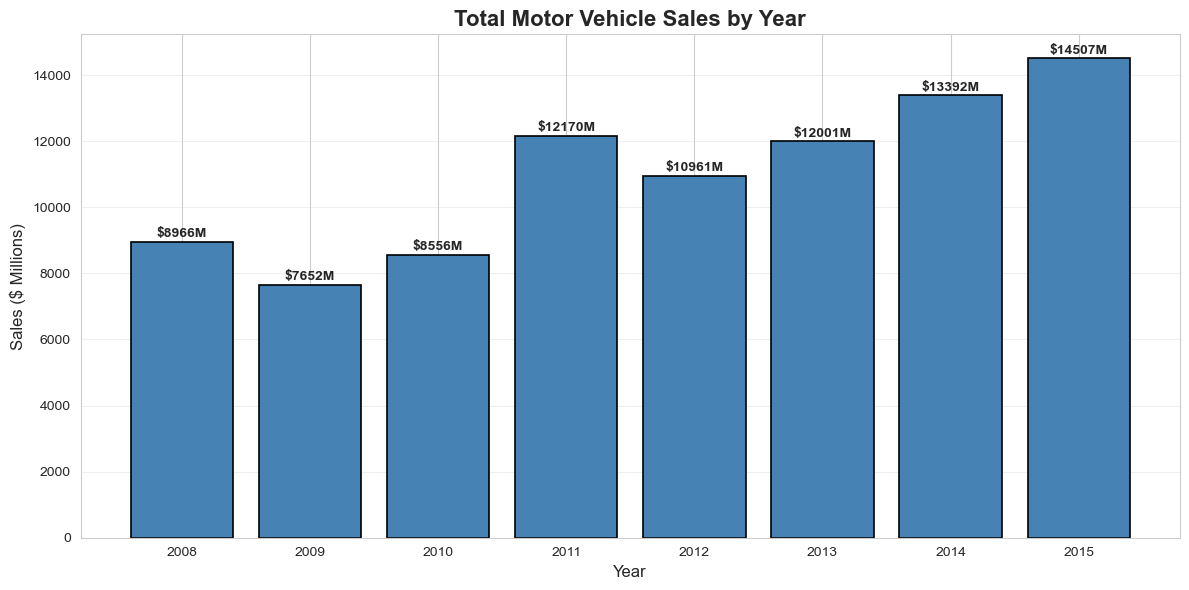


Year-over-Year Growth Rate:
   year  sales_millions  yoy_growth
0  2008        8965.561         NaN
1  2009        7652.500  -14.645609
2  2010        8556.088   11.807749
3  2011       12170.441   42.243055
4  2012       10960.876   -9.938547
5  2013       12000.615    9.485912
6  2014       13392.487   11.598339
7  2015       14506.732    8.319926


In [7]:
# Total sales by year
yearly_sales = df.groupby('year')['sales_millions'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.bar(yearly_sales['year'], yearly_sales['sales_millions'], 
        color='steelblue', edgecolor='black', linewidth=1.2)
plt.title('Total Motor Vehicle Sales by Year', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Sales ($ Millions)', fontsize=12)
plt.xticks(yearly_sales['year'])
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(yearly_sales['sales_millions']):
    plt.text(yearly_sales['year'].iloc[i], v + 50, f'${v:.0f}M', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate year-over-year growth
yearly_sales['yoy_growth'] = yearly_sales['sales_millions'].pct_change() * 100
print("\nYear-over-Year Growth Rate:")
print(yearly_sales[['year', 'sales_millions', 'yoy_growth']])

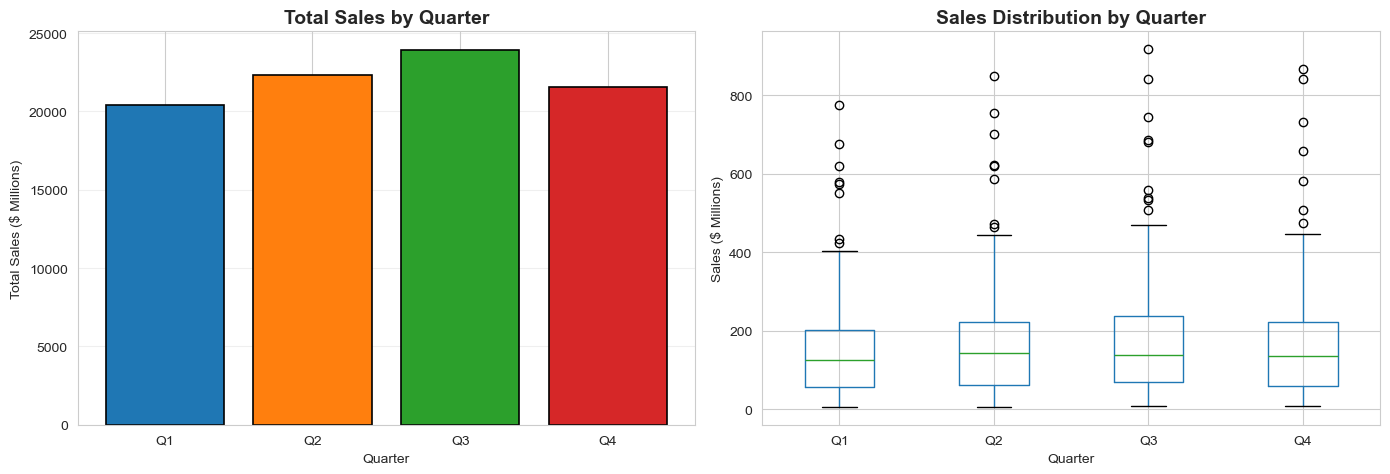


Quarterly Sales Summary:
   Quarter  Total Sales  Average Sales
0        1    20376.846     163.014768
1        2    22343.294     178.746352
2        3    23914.934     191.319472
3        4    21570.226     171.192270


In [8]:
# Sales by quarter
quarterly_sales = df.groupby('quarter')['sales_millions'].agg(['sum', 'mean']).reset_index()
quarterly_sales.columns = ['Quarter', 'Total Sales', 'Average Sales']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Total sales by quarter
axes[0].bar(quarterly_sales['Quarter'], quarterly_sales['Total Sales'], 
            color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], 
            edgecolor='black', linewidth=1.2)
axes[0].set_title('Total Sales by Quarter', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Quarter')
axes[0].set_ylabel('Total Sales ($ Millions)')
axes[0].set_xticks([1, 2, 3, 4])
axes[0].set_xticklabels(['Q1', 'Q2', 'Q3', 'Q4'])
axes[0].grid(axis='y', alpha=0.3)

# Box plot by quarter
df.boxplot(column='sales_millions', by='quarter', ax=axes[1])
axes[1].set_title('Sales Distribution by Quarter', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Quarter')
axes[1].set_ylabel('Sales ($ Millions)')
axes[1].set_xticklabels(['Q1', 'Q2', 'Q3', 'Q4'])
plt.suptitle('')

plt.tight_layout()
plt.show()

print("\nQuarterly Sales Summary:")
print(quarterly_sales)

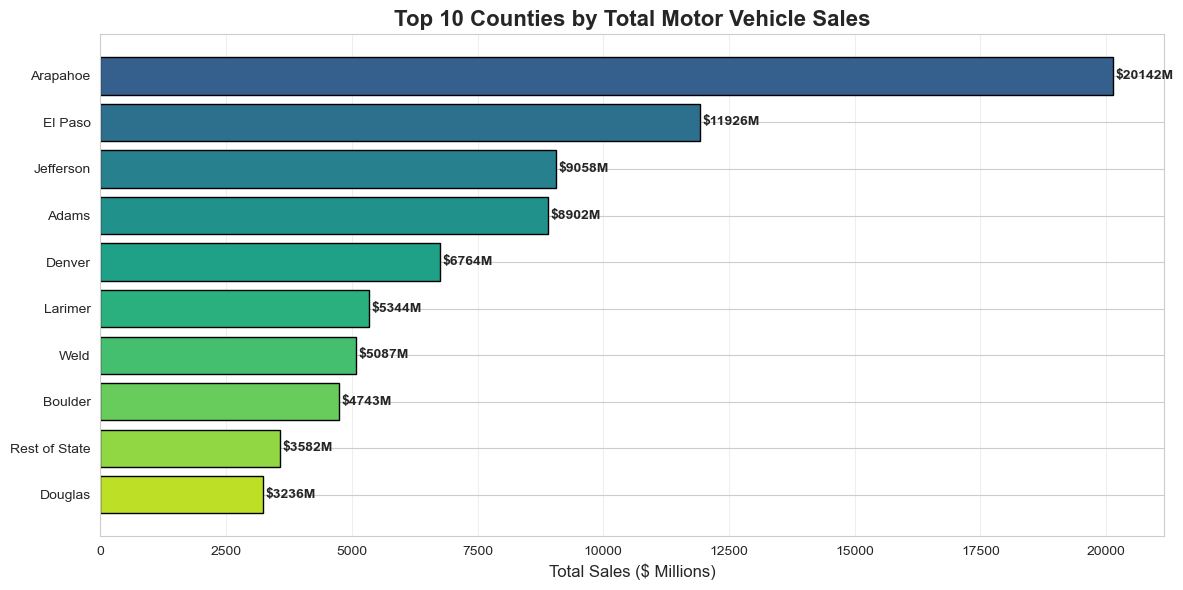


Top 10 Counties by Sales:
county
Arapahoe         20142.323
El Paso          11926.044
Jefferson         9058.407
Adams             8902.115
Denver            6763.613
Larimer           5344.367
Weld              5086.889
Boulder           4742.532
Rest of State     3582.170
Douglas           3236.493
Name: sales_millions, dtype: float64


In [9]:
# Top 10 counties by total sales
county_sales = df.groupby('county')['sales_millions'].sum().sort_values(ascending=False)
top_10_counties = county_sales.head(10)

plt.figure(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, 10))
bars = plt.barh(range(10), top_10_counties.values, color=colors, edgecolor='black', linewidth=1)
plt.yticks(range(10), top_10_counties.index)
plt.xlabel('Total Sales ($ Millions)', fontsize=12)
plt.title('Top 10 Counties by Total Motor Vehicle Sales', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, (county, value) in enumerate(top_10_counties.items()):
    plt.text(value + 50, i, f'${value:.0f}M', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nTop 10 Counties by Sales:")
print(top_10_counties)

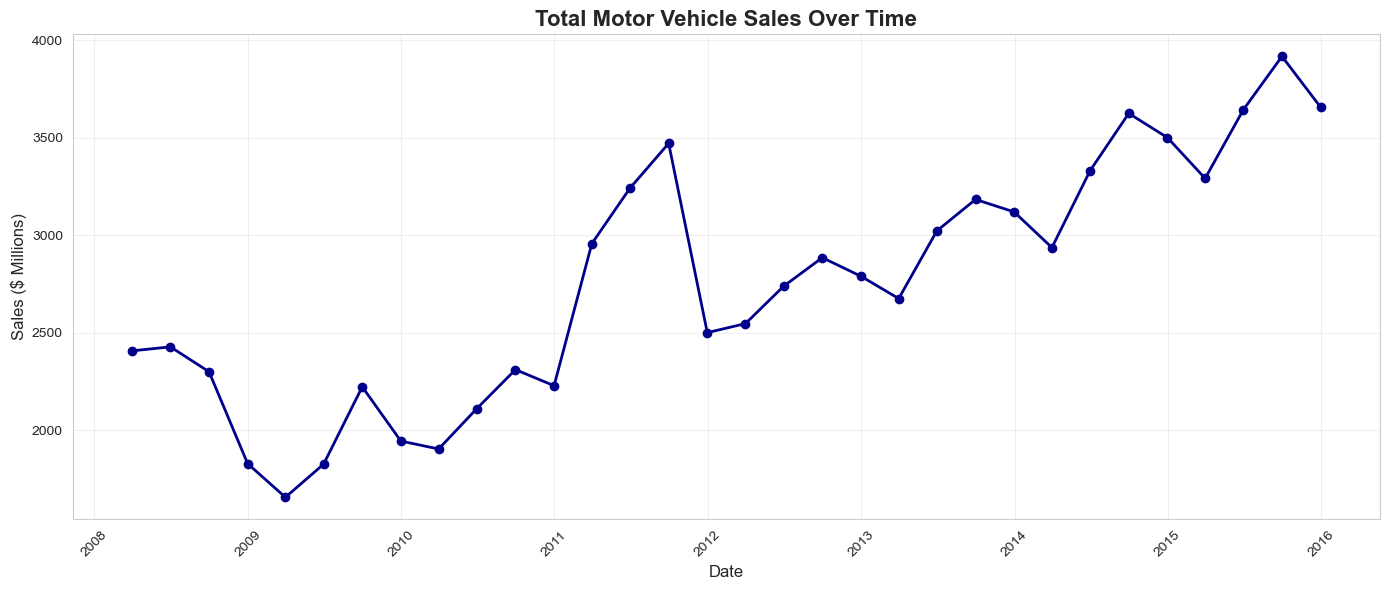

In [10]:
# Time series: Total sales over time
time_series = df.groupby('date')['sales_millions'].sum().reset_index()

plt.figure(figsize=(14, 6))
plt.plot(time_series['date'], time_series['sales_millions'], 
         marker='o', linewidth=2, markersize=6, color='darkblue')
plt.title('Total Motor Vehicle Sales Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales ($ Millions)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

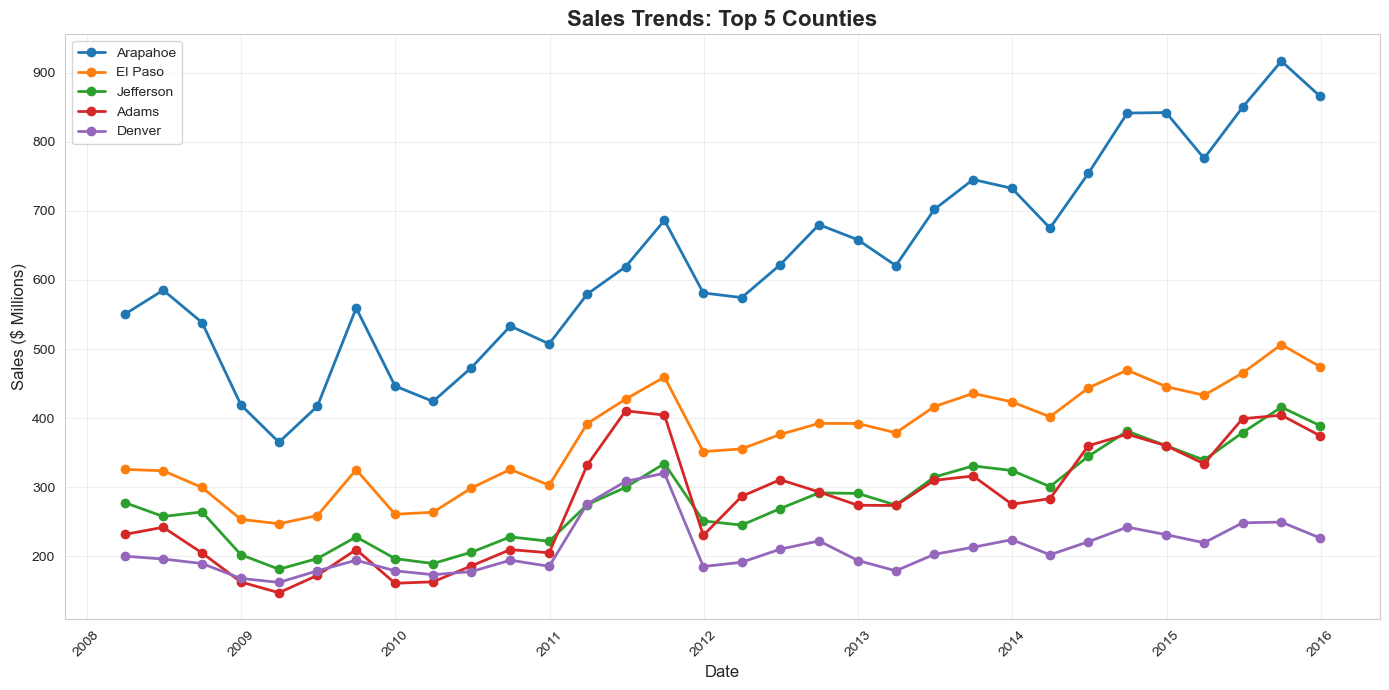

In [11]:
# Sales trends for top 5 counties
top_5_counties = county_sales.head(5).index

plt.figure(figsize=(14, 7))
for county in top_5_counties:
    county_data = df[df['county'] == county].groupby('date')['sales_millions'].sum()
    plt.plot(county_data.index, county_data.values, marker='o', linewidth=2, label=county)

plt.title('Sales Trends: Top 5 Counties', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales ($ Millions)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##  Statistical Analysis

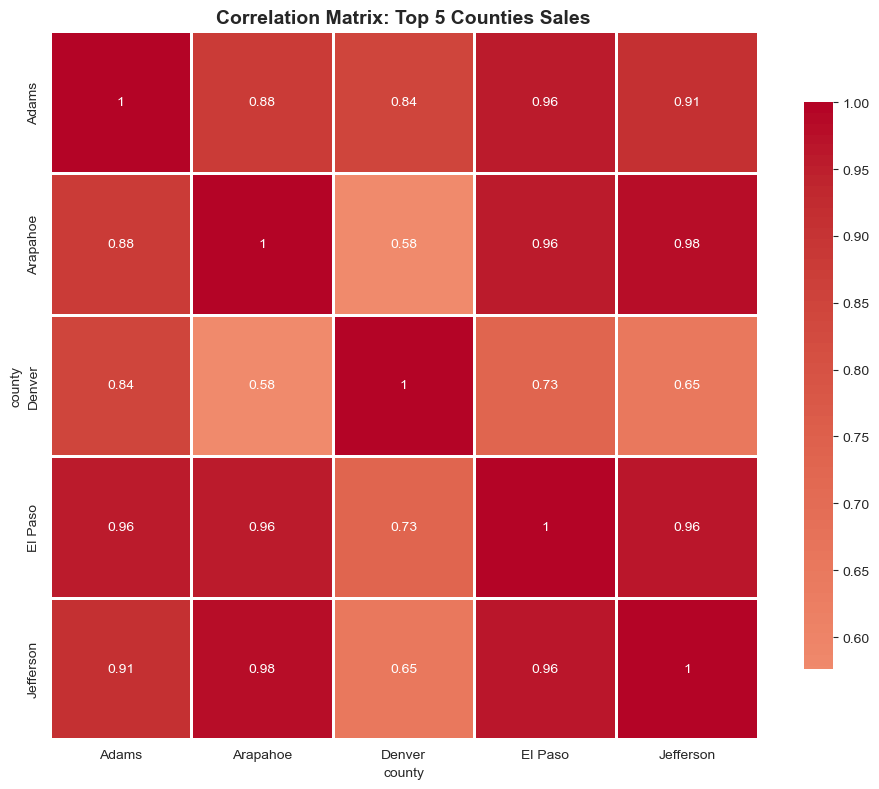


Correlation Matrix:
county        Adams  Arapahoe    Denver   El Paso  Jefferson
county                                                      
Adams      1.000000  0.877700  0.843844  0.955413   0.906423
Arapahoe   0.877700  1.000000  0.576499  0.958850   0.980076
Denver     0.843844  0.576499  1.000000  0.731329   0.652075
El Paso    0.955413  0.958850  0.731329  1.000000   0.962156
Jefferson  0.906423  0.980076  0.652075  0.962156   1.000000


In [12]:
# Correlation analysis for top counties
top_counties_pivot = df[df['county'].isin(top_5_counties)].pivot_table(
    values='sales_millions',
    index='date',
    columns='county',
    aggfunc='sum'
)

correlation_matrix = top_counties_pivot.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Top 5 Counties Sales', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCorrelation Matrix:")
print(correlation_matrix)

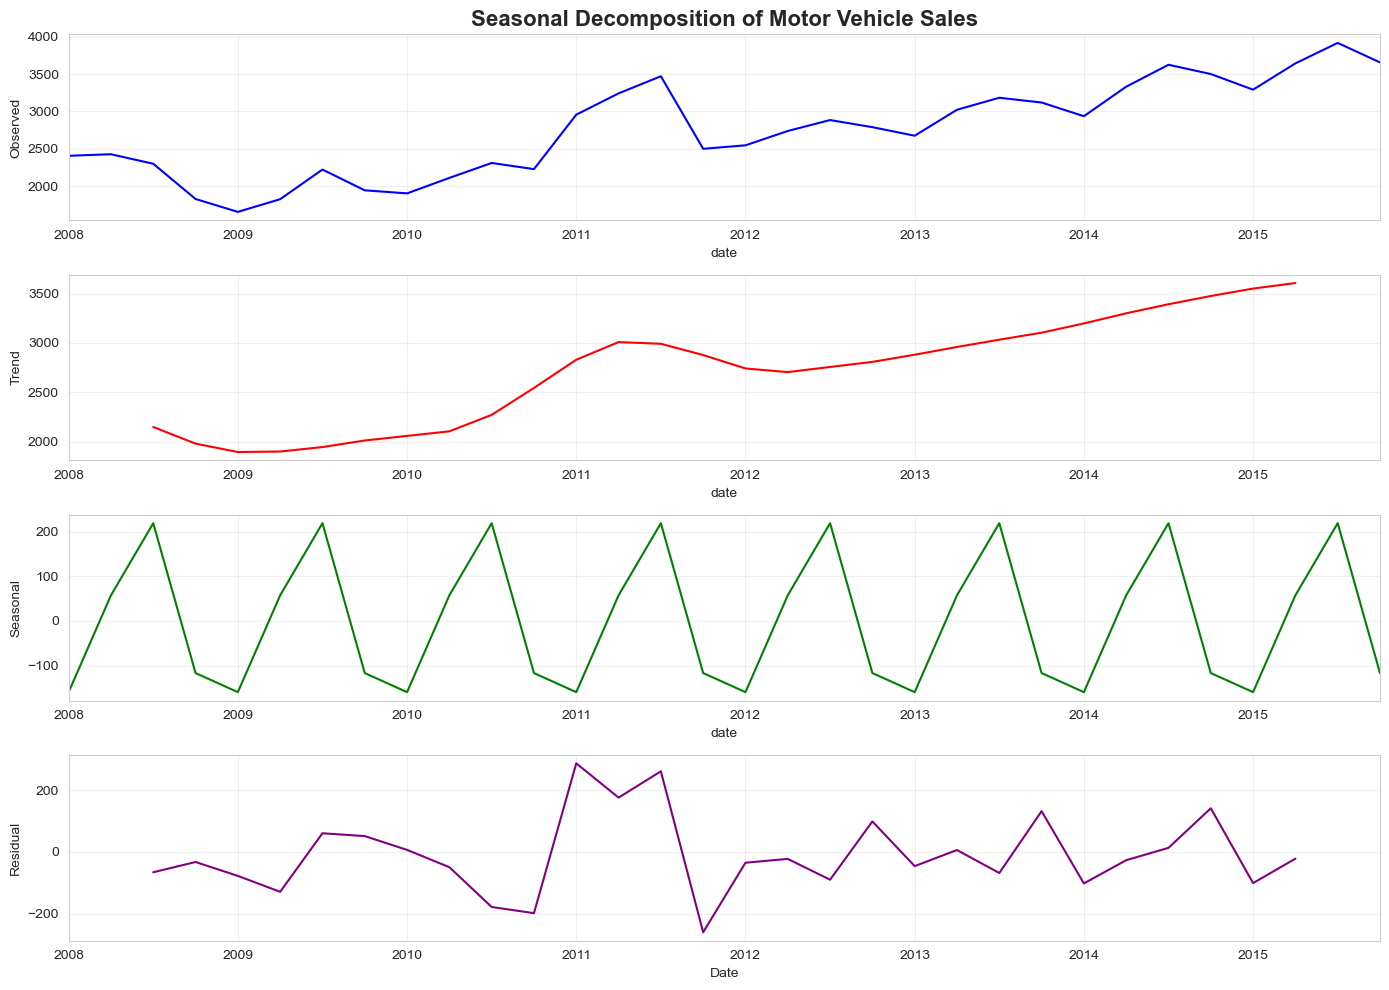

In [13]:
# Seasonal decomposition
ts_data = df.groupby('date')['sales_millions'].sum().sort_index()

# Perform seasonal decomposition
decomposition = seasonal_decompose(ts_data, model='additive', period=4)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(14, 10))

decomposition.observed.plot(ax=axes[0], color='blue')
axes[0].set_ylabel('Observed')
axes[0].set_title('Seasonal Decomposition of Motor Vehicle Sales', fontsize=16, fontweight='bold')
axes[0].grid(True, alpha=0.3)

decomposition.trend.plot(ax=axes[1], color='red')
axes[1].set_ylabel('Trend')
axes[1].grid(True, alpha=0.3)

decomposition.seasonal.plot(ax=axes[2], color='green')
axes[2].set_ylabel('Seasonal')
axes[2].grid(True, alpha=0.3)

decomposition.resid.plot(ax=axes[3], color='purple')
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Date')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
# Augmented Dickey-Fuller test for stationarity
adf_result = adfuller(ts_data.dropna())

print("\n" + "=" * 60)
print("STATIONARITY TEST (Augmented Dickey-Fuller)")
print("=" * 60)
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"P-value: {adf_result[1]:.4f}")
print(f"\nCritical Values:")
for key, value in adf_result[4].items():
    print(f"  {key}: {value:.3f}")

if adf_result[1] <= 0.05:
    print("\n Result: Series is STATIONARY (reject null hypothesis)")
else:
    print("\n Result: Series is NON-STATIONARY (fail to reject null hypothesis)")


STATIONARITY TEST (Augmented Dickey-Fuller)
ADF Statistic: -0.4004
P-value: 0.9100

Critical Values:
  1%: -3.724
  5%: -2.986
  10%: -2.633

 Result: Series is NON-STATIONARY (fail to reject null hypothesis)


##  Predictive Modeling

###  Time Series Forecasting (ARIMA)

In [15]:
# Fit ARIMA model
print("Training ARIMA model...")
arima_model = ARIMA(ts_data, order=(2, 1, 2))
arima_fit = arima_model.fit()

print("\n" + "=" * 60)
print("ARIMA MODEL SUMMARY")
print("=" * 60)
print(arima_fit.summary())

Training ARIMA model...

ARIMA MODEL SUMMARY
                               SARIMAX Results                                
Dep. Variable:         sales_millions   No. Observations:                   32
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -216.056
Date:                Mon, 24 Nov 2025   AIC                            442.111
Time:                        20:41:07   BIC                            449.281
Sample:                    03-31-2008   HQIC                           444.449
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0431      0.225      0.191      0.848      -0.398       0.485
ar.L2         -0.9902      0.101     -9.761      0.000      -1.189      -0.791
ma.L1  

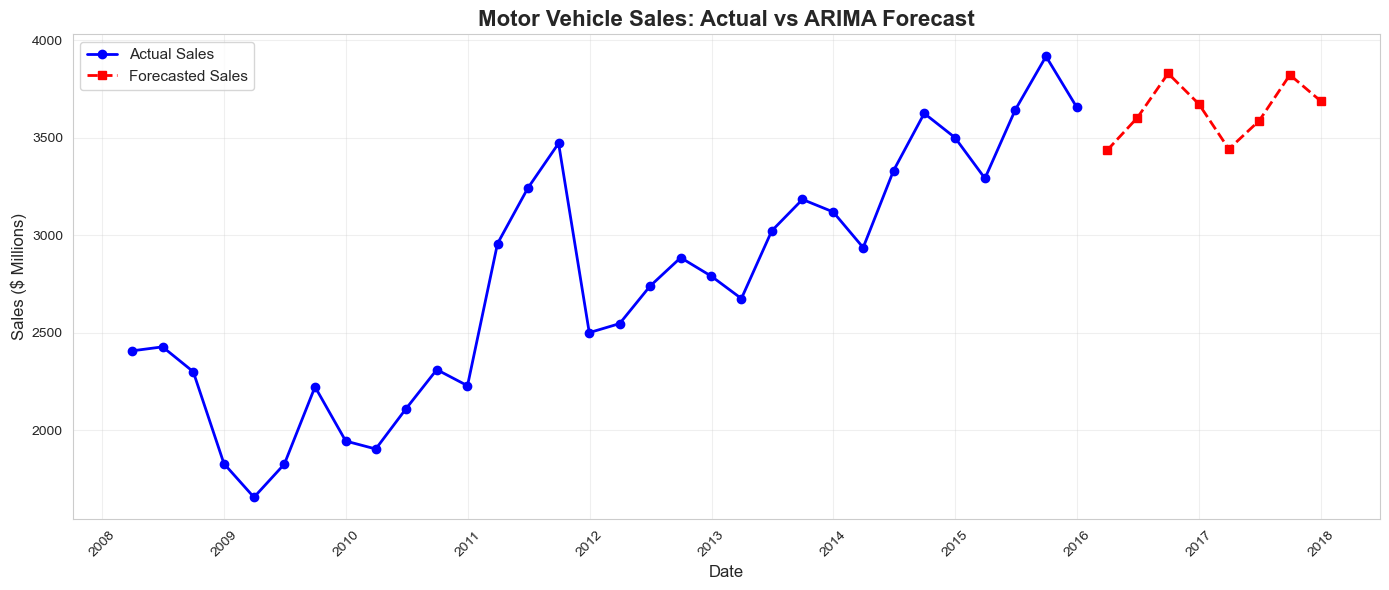


Forecasted Sales for Next 8 Quarters:
        Date  Forecasted Sales ($M)
0 2016-03-31            3434.732575
1 2016-06-30            3602.644984
2 2016-09-30            3829.151623
3 2016-12-31            3672.642473
4 2017-03-31            3441.622305
5 2017-06-30            3586.645897
6 2017-09-30            3821.640678
7 2017-12-31            3688.160931


In [16]:
# Forecast next 8 quarters (2 years)
forecast_steps = 8
forecast = arima_fit.forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=ts_data.index[-1], periods=forecast_steps+1, freq='Q')[1:]

# Plot actual vs forecast
plt.figure(figsize=(14, 6))
plt.plot(ts_data.index, ts_data.values, marker='o', linewidth=2, label='Actual Sales', color='blue')
plt.plot(forecast_index, forecast, marker='s', linewidth=2, label='Forecasted Sales', 
         color='red', linestyle='--')
plt.title('Motor Vehicle Sales: Actual vs ARIMA Forecast', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales ($ Millions)', fontsize=12)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nForecasted Sales for Next 8 Quarters:")
forecast_df = pd.DataFrame({
    'Date': forecast_index,
    'Forecasted Sales ($M)': forecast.values
})
print(forecast_df)

###  Machine Learning Model (Random Forest)

In [17]:
# Prepare data for machine learning
ml_df = df.copy()

# Encode county as categorical
ml_df['county_encoded'] = ml_df['county'].astype('category').cat.codes

# Define features and target
X = ml_df[['year', 'quarter', 'county_encoded']]
y = ml_df['sales_millions']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 400
Test set size: 101


In [18]:
# Train Random Forest model
print("Training Random Forest model...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

# Evaluate model
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)

print("\n" + "=" * 60)
print("RANDOM FOREST MODEL PERFORMANCE")
print("=" * 60)
print(f"\nTraining Set:")
print(f"  RMSE: ${train_rmse:.2f}M")
print(f"  R² Score: {train_r2:.4f}")
print(f"\nTest Set:")
print(f"  RMSE: ${test_rmse:.2f}M")
print(f"  MAE: ${test_mae:.2f}M")
print(f"  R² Score: {test_r2:.4f}")

Training Random Forest model...

RANDOM FOREST MODEL PERFORMANCE

Training Set:
  RMSE: $10.86M
  R² Score: 0.9956

Test Set:
  RMSE: $21.21M
  MAE: $14.58M
  R² Score: 0.9829


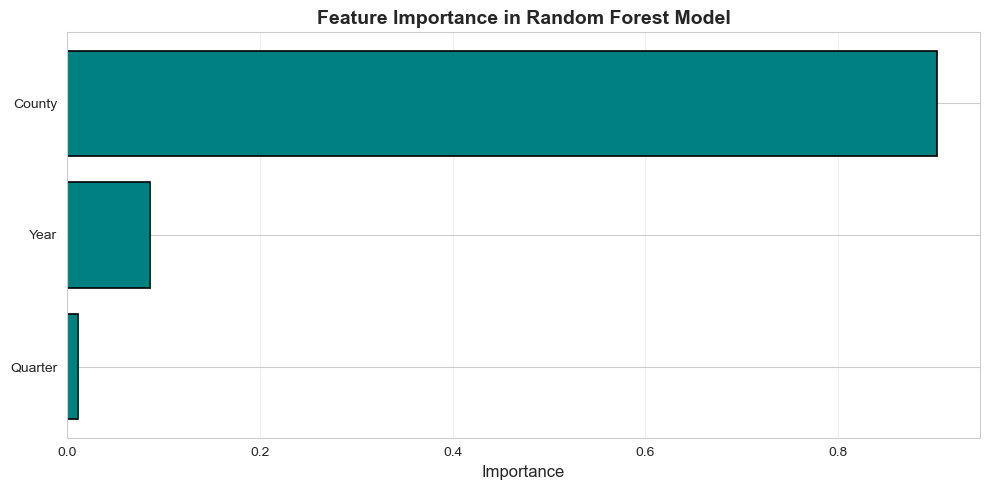


Feature Importance:
   Feature  Importance
2   County    0.901980
0     Year    0.086277
1  Quarter    0.011744


In [19]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': ['Year', 'Quarter', 'County'],
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 5))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], 
         color='teal', edgecolor='black', linewidth=1.2)
plt.xlabel('Importance', fontsize=12)
plt.title('Feature Importance in Random Forest Model', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nFeature Importance:")
print(feature_importance)

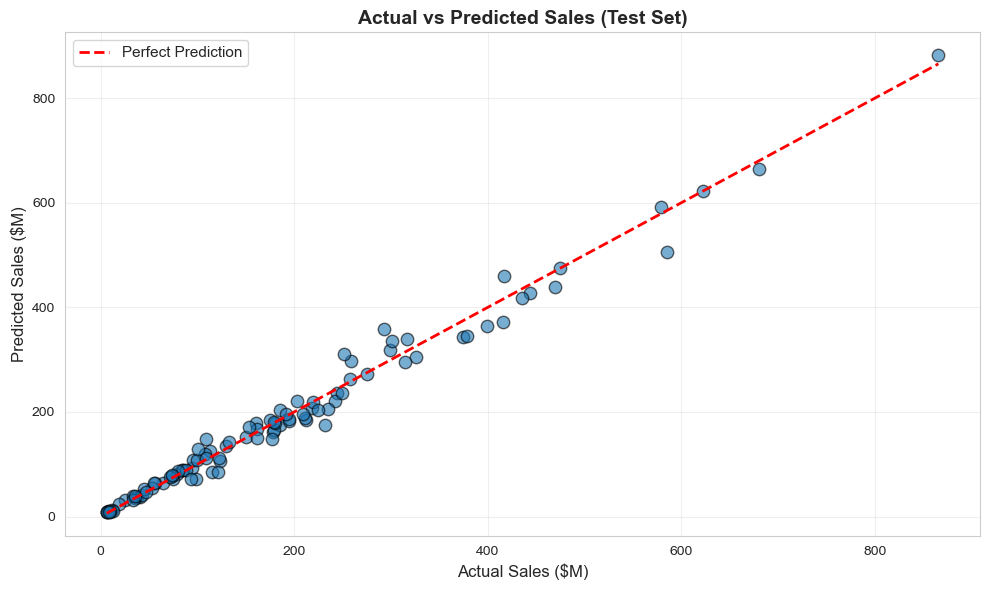

In [20]:
# Actual vs Predicted plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6, edgecolor='black', s=80)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Sales ($M)', fontsize=12)
plt.ylabel('Predicted Sales ($M)', fontsize=12)
plt.title('Actual vs Predicted Sales (Test Set)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

##  Final Report Summary

In [21]:
report = f"""
{'=' * 80}
COLORADO MOTOR VEHICLE SALES DATA ANALYSIS REPORT
{'=' * 80}

1. DATA OVERVIEW
{'─' * 80}
   • Time Period: {df['year'].min()} - {df['year'].max()}
   • Total Records: {len(df):,}
   • Number of Counties: {df['county'].nunique()}
   • Total Sales: ${df['sales_millions'].sum():.2f}M

2. KEY FINDINGS
{'─' * 80}
   • Average Quarterly Sales: ${df['sales_millions'].mean():.2f}M
   • Peak Sales Year: {yearly_sales.loc[yearly_sales['sales_millions'].idxmax(), 'year']}
   • Top County: {county_sales.index[0]} (${county_sales.values[0]:.2f}M total)
   • Most Sales Quarter: Q{quarterly_sales.loc[quarterly_sales['Total Sales'].idxmax(), 'Quarter']}

3. STATISTICAL ANALYSIS
{'─' * 80}
   • Seasonal Pattern: Identified quarterly seasonality in sales data
   • Trend: Overall {'upward' if yearly_sales['yoy_growth'].mean() > 0 else 'downward'} trend observed
   • Correlation: Strong positive correlation among top county sales

4. PREDICTIVE MODELING
{'─' * 80}
   
   ARIMA Model (Time Series Forecasting):
   • Model: ARIMA(2,1,2)
   • Forecast Horizon: 8 quarters (2 years)
   • Next Quarter Forecast: ${forecast.values[0]:.2f}M
   
   Random Forest Model:
   • Test RMSE: ${test_rmse:.2f}M
   • Test R² Score: {test_r2:.4f}
   • Test MAE: ${test_mae:.2f}M
   • Most Important Feature: {feature_importance.iloc[0]['Feature']}

5. BUSINESS INSIGHTS
{'─' * 80}
   • Denver metro area (Arapahoe, Denver, Jefferson) dominates sales
   • Q4 typically shows strongest sales performance
   • County location is the most important predictor of sales
   • Sales show recovery trend after 2008 financial crisis

6. RECOMMENDATIONS
{'─' * 80}
   • Focus marketing efforts in high-performing counties
   • Increase inventory in Q4 to meet seasonal demand
   • Monitor economic indicators for early warning of sales shifts
   • Develop county-specific strategies based on local trends

{'=' * 80}
Report Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
{'=' * 80}
"""

print(report)


COLORADO MOTOR VEHICLE SALES DATA ANALYSIS REPORT

1. DATA OVERVIEW
────────────────────────────────────────────────────────────────────────────────
   • Time Period: 2008 - 2015
   • Total Records: 501
   • Number of Counties: 17
   • Total Sales: $88205.30M

2. KEY FINDINGS
────────────────────────────────────────────────────────────────────────────────
   • Average Quarterly Sales: $176.06M
   • Peak Sales Year: 2015
   • Top County: Arapahoe ($20142.32M total)
   • Most Sales Quarter: Q3

3. STATISTICAL ANALYSIS
────────────────────────────────────────────────────────────────────────────────
   • Seasonal Pattern: Identified quarterly seasonality in sales data
   • Trend: Overall upward trend observed
   • Correlation: Strong positive correlation among top county sales

4. PREDICTIVE MODELING
────────────────────────────────────────────────────────────────────────────────
   
   ARIMA Model (Time Series Forecasting):
   • Model: ARIMA(2,1,2)
   • Forecast Horizon: 8 quarters (2 ye

##  Export Results

In [23]:
# Save forecast results
forecast_df.to_csv('sales_forecast.csv', index=False)
print(" Forecast results saved to 'sales_forecast.csv'")

# Save model performance
performance_df = pd.DataFrame({
    'Metric': ['Train RMSE', 'Test RMSE', 'Test MAE', 'Test R²'],
    'Value': [train_rmse, test_rmse, test_mae, test_r2]
})
performance_df.to_csv('model_performance.csv', index=False)
print(" Model performance saved to 'model_performance.csv'")

print("\n Analysis completed successfully!")

 Forecast results saved to 'sales_forecast.csv'
 Model performance saved to 'model_performance.csv'

 Analysis completed successfully!
